# Fluzz ‚Äî D√©tection de fraude bancaire  
**Partie 1 ‚Äî Documentation (Module 1)**

> Notebook pr√™t-√†-l'emploi pour documenter le *jeu de donn√©es*, analyser son *sch√©ma* et d√©crire le *cycle de vie des donn√©es* (acquisition ‚Üí stockage ‚Üí transformations ‚Üí livraison du mod√®le).


## 1) Contexte & provenance (interne Fluzz)  
- **Organisation** : Fluzz, √©quipe *Data Risk & Fraud*.  
- **Source interne** : export s√©curis√© des *transactions cartes* issu du data lake (*zone curated*), dataset d√©j√† **anonymis√©** et **pseudonymis√©** par notre service.  
- **Nature des variables** : les colonnes `V1` √† `V28` sont des *composites* (projections lin√©aires internes), analogues √† des composantes (type *cross-features* / projections PCA-like) ‚Äî les variables brutes ne sont **pas** expos√©es pour des raisons de confidentialit√©.  
- **Colonnes non projet√©es** : `Time` (secondes √©coul√©es depuis la premi√®re transaction du lot) et `Amount` (montant). La cible est `Class` (1 = fraude, 0 = non fraude).  
- **Fen√™tre temporelle** : lot de transactions sur une p√©riode courte (‚âà 2 jours).   
- **Objectif m√©tier** : entra√Æner un mod√®le de classification pour d√©tecter des transactions frauduleuses en temps (quasi) r√©el et r√©duire les faux positifs c√¥t√© clients/support.

**Note de contexte (externe, pour culture g√©n√©rale)** : le dataset public Kaggle *Credit Card Fraud Detection* pr√©sente des caract√©ristiques tr√®s proches (284‚ÄØ807 lignes, variables `V1..V28` projet√©es, fort d√©s√©quilibre de classe). Ici, on **raisonne comme si** la donn√©e provenait nativement de Fluzz et restait confidentielle.


## 2) Vue d‚Äôensemble du dataset (auto-r√©cap)

- **Taille** : 284,807 lignes √ó 31 colonnes  
- **Aper√ßu des colonnes** : Time, V1, V2, V3, V4, V5, V6, V7, V8, V9 ...  
- **Types principaux** : float64: 30, int64: 1  
- **D√©s√©quilibre (taux de fraude)** : ~0.173%  
- **M√©trique conseill√©e** : AUPRC (PR-AUC) plut√¥t qu‚Äôaccuracy (peu informative sur classes d√©s√©quilibr√©es).  


## 3) Dictionnaire de donn√©es 
Ce bloc produit un *data dictionary* avec : nom de colonne, type, nb valeurs manquantes, nb de valeurs uniques (si applicable), min/max (num√©riques). Un export CSV est √©galement enregistr√© pour la documentation.


In [1]:
# === Param√®tres ===
CSV_PATH = r"../01_data/creditcard.csv"  # Mettez √† jour si besoin

# Imports
import pandas as pd
import numpy as np

# Lecture
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)

(284807, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

In [2]:
# Aper√ßu rapide
print("Colonnes:", list(df.columns))
print()
print("Types:")
print(df.dtypes)
print()
print("Valeurs manquantes par colonne:")
print(df.isna().sum())

Colonnes: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Valeurs manquantes par colonne:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13   

In [3]:
# D√©s√©quilibre de classes
if "Class" in df.columns:
    counts = df["Class"].value_counts().sort_index()
    total = len(df)
    ratio = (counts.get(1, 0) / total) * 100
    print("Classe 0 (non fraude):", counts.get(0, 0))
    print("Classe 1 (fraude):    ", counts.get(1, 0))
    print(f"Taux de fraude: {ratio:.4f}%")
else:
    print("Colonne 'Class' absente ‚Äî v√©rifiez le fichier.")

Classe 0 (non fraude): 284315
Classe 1 (fraude):     492
Taux de fraude: 0.1727%


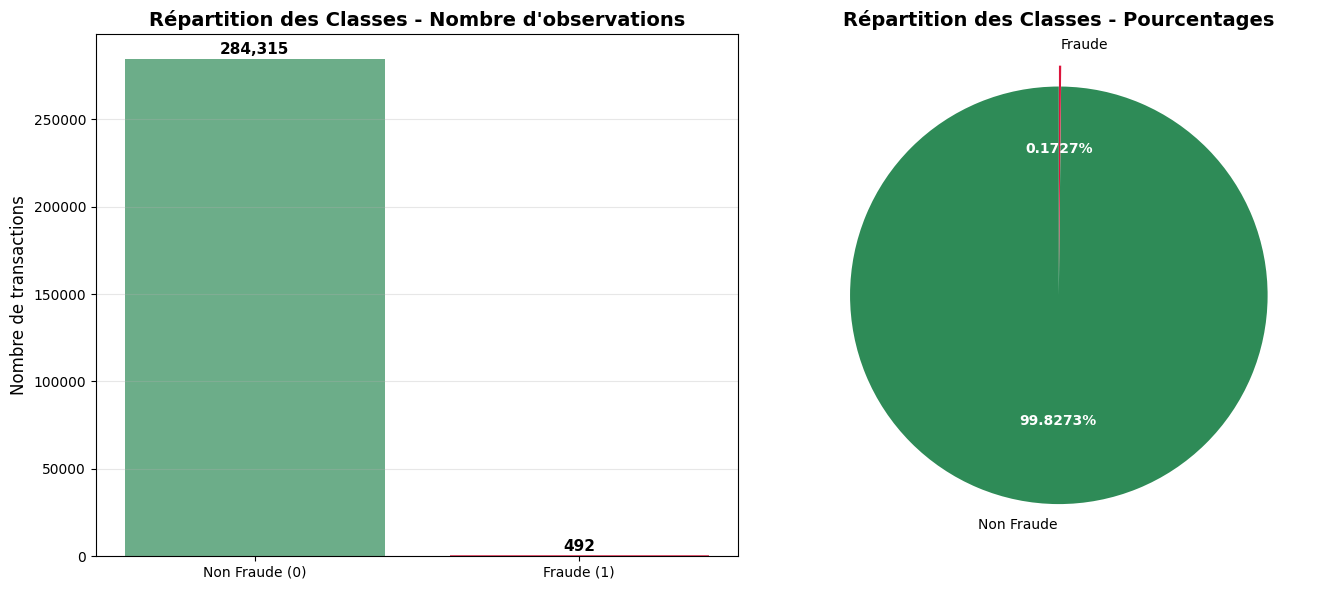


STATISTIQUES DE R√âPARTITION DES CLASSES
Total des transactions      : 284,807
Transactions non frauduleuses: 284,315 (99.8273%)
Transactions frauduleuses   : 492 (0.1727%)
Ratio de d√©s√©quilibre       : 1:577


In [4]:
# Visualisation de la r√©partition des classes
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
plt.style.use('default')
sns.set_palette("husl")

# Cr√©ation de la figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphique en barres
class_counts = df["Class"].value_counts().sort_index()
colors = ['#2E8B57', '#DC143C']  # Vert pour non-fraude, rouge pour fraude
bars = ax1.bar(['Non Fraude (0)', 'Fraude (1)'], class_counts.values, color=colors, alpha=0.7)
ax1.set_title('R√©partition des Classes - Nombre d\'observations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Nombre de transactions', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Graphique en camembert
labels = ['Non Fraude', 'Fraude']
sizes = class_counts.values
colors = ['#2E8B57', '#DC143C']
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.4f%%', 
                                  startangle=90, explode=(0, 0.1))
ax2.set_title('R√©partition des Classes - Pourcentages', fontsize=14, fontweight='bold')

# Am√©lioration de la lisibilit√© du camembert
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# Affichage des statistiques d√©taill√©es
total_transactions = len(df)
fraud_count = class_counts[1]
non_fraud_count = class_counts[0]
fraud_percentage = (fraud_count / total_transactions) * 100

print("\n" + "="*50)
print("STATISTIQUES DE R√âPARTITION DES CLASSES")
print("="*50)
print(f"Total des transactions      : {total_transactions:,}")
print(f"Transactions non frauduleuses: {non_fraud_count:,} ({(non_fraud_count/total_transactions)*100:.4f}%)")
print(f"Transactions frauduleuses   : {fraud_count:,} ({fraud_percentage:.4f}%)")
print(f"Ratio de d√©s√©quilibre       : 1:{non_fraud_count//fraud_count}")
print("="*50)

In [6]:
# G√©n√©ration d'un data dictionary
from pandas.api.types import is_numeric_dtype

rows = []
for col in df.columns:
    s = df[col]
    info = {
        "column": col,
        "dtype": str(s.dtype),
        "missing_count": int(s.isna().sum()),
        "unique_count": int(s.nunique(dropna=True))
    }
    if is_numeric_dtype(s):
        info.update({
            "min": float(np.nanmin(s)),
            "max": float(np.nanmax(s)),
            "mean": float(np.nanmean(s)),
            "std": float(np.nanstd(s))
        })
    rows.append(info)

data_dict = pd.DataFrame(rows).sort_values("column")
data_dict_path = "../PART_1/data/creditcard_dictionary.csv"
data_dict.to_csv(data_dict_path, index=False)
print(f"Data dictionary sauvegard√©: {data_dict_path}")
data_dict.head(10)

Data dictionary sauvegard√©: ../PART_1/data/creditcard_dictionary.csv


column    dtype  missing_count  unique_count        min            max  \
29  Amount  float64              0         32767   0.000000   25691.160000   
30   Class    int64              0             2   0.000000       1.000000   
0     Time  float64              0        124592   0.000000  172792.000000   
1       V1  float64              0        275663 -56.407510       2.454930   
10     V10  float64              0        275663 -24.588262      23.745136   
11     V11  float64              0        275663  -4.797473      12.018913   
12     V12  float64              0        275663 -18.683715       7.848392   
13     V13  float64              0        275663  -5.791881       7.126883   
14     V14  float64              0        275663 -19.214325      10.526766   
15     V15  float64              0        275663  -4.498945       8.877742   

            mean           std  
29  8.834962e+01    250.119670  
30  1.727486e-03      0.041527  
0   9.481386e+04  47488.062585  
1   1.168375e-15      1.958692  
10  2.239053e-15      1.088848  
11  1.673327e-15      1.020711  
12 -1.247012e-15      0.999200  
13  8.190001e-16      0.995272  
14  1.207294e-15      0.958594  
15  4.887456e-15      0.915314

## 4) Analyse de corr√©lation des variables V
Les variables `V1` √† `V28` sont des composantes transform√©es (projections PCA-like). Une analyse de corr√©lation nous aide √† comprendre les relations entre ces variables et identifier d'√©ventuelles redondances.

Nombre de variables V analys√©es: 28
Variables: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


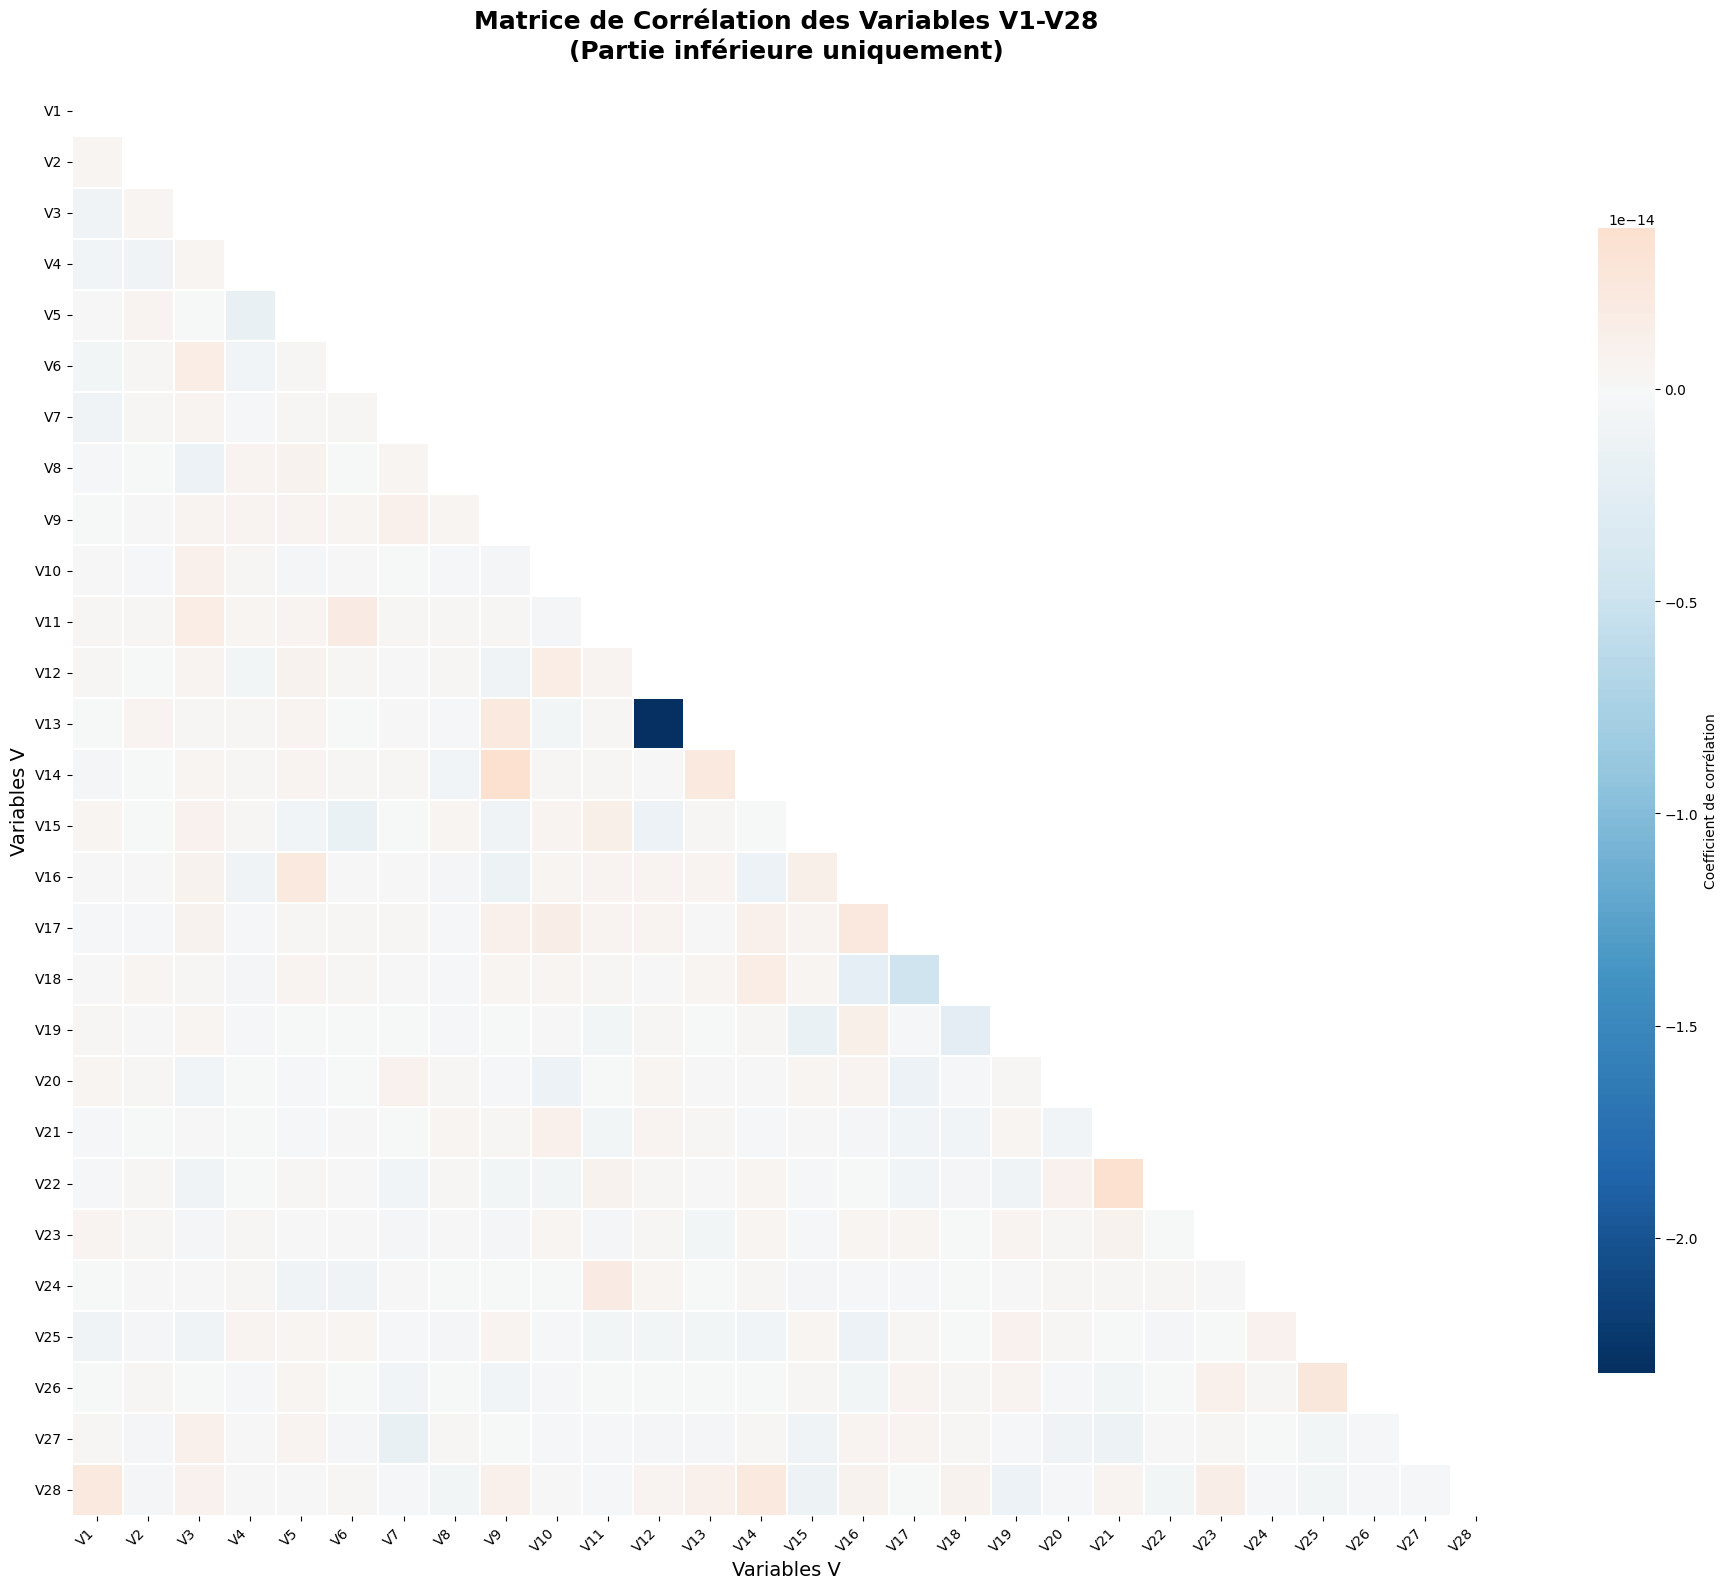


ANALYSE DES CORR√âLATIONS FORTES (|r| > 0.5)
Aucune corr√©lation forte (|r| > 0.5) d√©tect√©e entre les variables V.
Ceci est attendu pour des composantes PCA, qui sont orthogonales par construction.

üìä Statistiques des coefficients de corr√©lation:
Corr√©lation moyenne: -0.0000
Corr√©lation m√©diane: 0.0000
√âcart-type: 0.0000
Corr√©lation minimale: -0.0000
Corr√©lation maximale: 0.0000


In [10]:
# S√©lection des variables V pour l'analyse de corr√©lation
v_columns = [col for col in df.columns if col.startswith('V')]
print(f"Nombre de variables V analys√©es: {len(v_columns)}")
print(f"Variables: {v_columns}")

# Calcul de la matrice de corr√©lation
correlation_matrix = df[v_columns].corr()

# Configuration de la figure
plt.figure(figsize=(20, 16))

# Cr√©ation de la heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Masque pour n'afficher que la partie inf√©rieure
heatmap = sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,  # Pas d'annotations pour √©viter la surcharge
    cmap='RdBu_r',  # Palette de couleurs rouge-blanc-bleu
    center=0,  # Centre sur 0
    square=True,
    linewidths=0.1,
    cbar_kws={"shrink": 0.8, "label": "Coefficient de corr√©lation"}
)

# Personnalisation du graphique
plt.title('Matrice de Corr√©lation des Variables V1-V28\n(Partie inf√©rieure uniquement)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Variables V', fontsize=14)
plt.ylabel('Variables V', fontsize=14)

# Rotation des labels pour une meilleure lisibilit√©
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Analyse des corr√©lations fortes (absolues > 0.5)
print("\n" + "="*80)
print("ANALYSE DES CORR√âLATIONS FORTES (|r| > 0.5)")
print("="*80)

# Cr√©ation d'un DataFrame pour stocker les corr√©lations fortes
strong_correlations = []
for i in range(len(v_columns)):
    for j in range(i+1, len(v_columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            strong_correlations.append({
                'Variable_1': v_columns[i],
                'Variable_2': v_columns[j],
                'Corr√©lation': corr_value,
                'Corr√©lation_abs': abs(corr_value)
            })

if strong_correlations:
    strong_corr_df = pd.DataFrame(strong_correlations)
    strong_corr_df = strong_corr_df.sort_values('Corr√©lation_abs', ascending=False)
    print(f"Nombre de paires avec corr√©lation forte: {len(strong_corr_df)}")
    print("\nTop 10 des corr√©lations les plus fortes:")
    display(strong_corr_df.head(10)[['Variable_1', 'Variable_2', 'Corr√©lation']])
else:
    print("Aucune corr√©lation forte (|r| > 0.5) d√©tect√©e entre les variables V.")
    print("Ceci est attendu pour des composantes PCA, qui sont orthogonales par construction.")

# Statistiques descriptives de la matrice de corr√©lation
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
print(f"\nüìä Statistiques des coefficients de corr√©lation:")
print(f"Corr√©lation moyenne: {np.mean(corr_values):.4f}")
print(f"Corr√©lation m√©diane: {np.median(corr_values):.4f}")
print(f"√âcart-type: {np.std(corr_values):.4f}")
print(f"Corr√©lation minimale: {np.min(corr_values):.4f}")
print(f"Corr√©lation maximale: {np.max(corr_values):.4f}")
print("="*80)